# Customer Segmentation with K-Means Clustering

## 1. Project Goal

The goal of this project is to apply unsupervised machine learning to identify distinct customer segments within a dataset from a shopping mall. By using the **K-Means clustering algorithm**, we aim to group customers based on their purchasing behavior and demographics without any pre-existing labels.

The ultimate business objective is to provide the mall's marketing team with actionable insights into their customer base, enabling them to move from a generic marketing strategy to one that is targeted and personalized for each identified segment.

## 2. The Dataset

The dataset contains basic demographic and spending information for 200 mall customers.

*   **Source:** [Kaggle - Mall Customer Segmentation Data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

### Data Dictionary
*   **CustomerID:** A unique identifier for each customer.
*   **Gender:** The gender of the customer.
*   **Age:** The age of the customer.
*   **Annual Income (k$):** The annual income of the customer in thousands of dollars.
*   **Spending Score (1-100):** A score assigned by the mall based on customer behavior and spending habits. This is a key behavioral metric.

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from google.colab import drive

# --- Custom Utility Functions ---
# drive.mount('/content/drive')
utils_path = '../utils'
sys.path.append(utils_path)
import eda_utils

# --- 2. LOAD DATA ---
file_path = './data/Mall_Customers.csv'
df = pd.read_csv(file_path)

# --- 3. INITIAL EXPLORATION ---
# Let's run our initial report.
eda_utils.initial_report(df)

--- Initial Data Report ---

--- Shape ---
Rows: 200, Columns: 5

--- Data Types & Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

--- First 5 Rows (Head) ---
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                    

## 2. Data Cleaning and Preparation

The initial report shows an exceptionally clean dataset with no missing values or duplicates. Our preparation will focus on two simple but important steps:

1.  **Standardize Column Names:** Convert all column names to a consistent `snake_case` format for ease of use.
2.  **Drop the Identifier:** Remove the non-informative `CustomerID` column.

In [2]:
# --- 1. Standardize Column Names ---
# We'll create a simple mapping for this small number of columns for clarity.
df.rename(columns={
    'Gender': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'annual_income_k',
    'Spending Score (1-100)': 'spending_score'
}, inplace=True)

# Drop the CustomerID column
df.drop(columns=['CustomerID'], inplace=True)


# --- 2. Verification ---
print("--- Cleaned DataFrame ---")
df.info()
print("\n")
print(df.head())

--- Cleaned DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           200 non-null    object
 1   age              200 non-null    int64 
 2   annual_income_k  200 non-null    int64 
 3   spending_score   200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


   gender  age  annual_income_k  spending_score
0    Male   19               15              39
1    Male   21               15              81
2  Female   20               16               6
3  Female   23               16              77
4  Female   31               17              40


## 3. Exploratory Data Analysis (Pre-Clustering)

Before we apply any clustering algorithms, it's important to understand the distributions of our key features and the relationships between them. A `pairplot` is an excellent tool for this, as it provides a single, comprehensive visualization of all pairwise relationships.

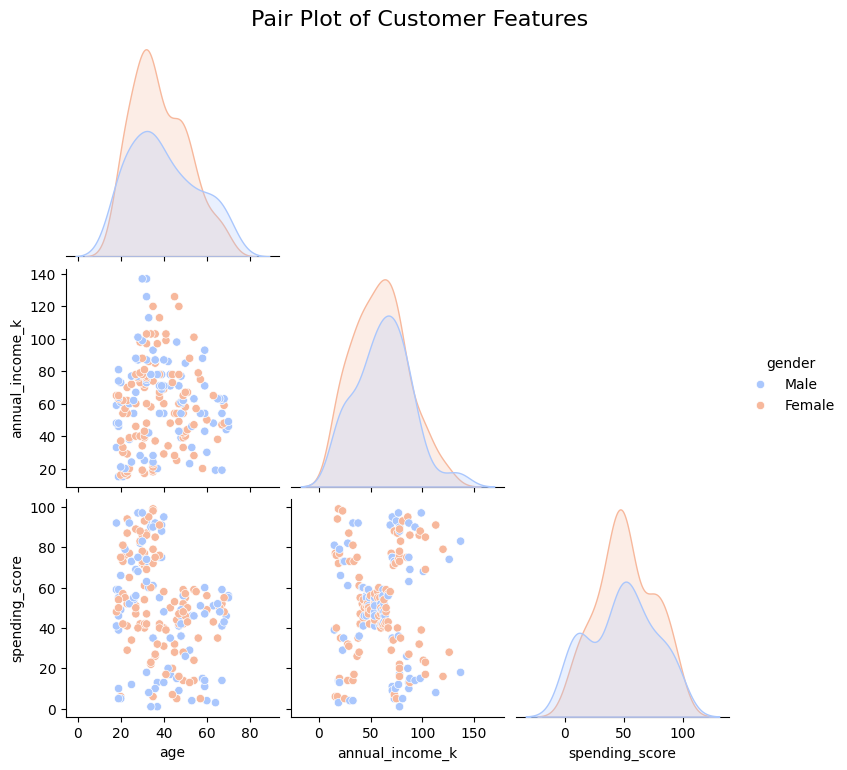

In [3]:
# Create a pair plot to visualize relationships
# We'll color the points by 'gender' to see if there are any obvious differences.
sns.pairplot(df, hue='gender', palette='coolwarm', corner=True) # corner=True avoids redundant plots
plt.suptitle('Pair Plot of Customer Features', y=1.02, fontsize=16)
plt.show()

**Observations from the Pair Plot:**

The pair plot provides a rich, high-level overview of our customer data and reveals several crucial patterns:

1.  **Distributions (`histograms` on the diagonal):**
    *   `age`: Shows a relatively wide and varied distribution, with notable peaks in the early 20s/30s and again in the late 40s.
    *   `annual_income_k`: Is somewhat normally distributed but slightly skewed to the right.
    *   `spending_score`: Is the most interesting. It has a large central peak around the 40-60 mark, suggesting many "average" spenders.

2.  **Gender Differences:** Coloring by `gender` shows that the distributions for males and females are **very similar** across all features. The peaks for females are slightly higher simply because there are more females (112) than males (88) in the dataset. This suggests that `gender` is likely **not a primary driver** for the main spending segments. We can probably exclude it from our clustering model to keep it simple.

3.  **Relationships with `age`:** The scatter plots involving `age` do not show a clear, distinct linear or clustered pattern. While there might be subtle trends (e.g., spending score might dip slightly in middle age), it's not the primary driver of the distinct groups.

4.  **The `annual_income_k` vs. `spending_score`:** This is the most important scatter plot in the grid, and your interpretation was perfect. We can visually identify potential clusters:
    *   A dense, central cluster of "average" customers (medium income, medium spending).
    *   Four distinct "arms and legs" reaching out:
        *   Top-Left: Low Income, High Spending Score.
        *   Top-Right: High Income, High Spending Score.
        *   Bottom-Left: Low Income, Low Spending Score.
        *   Bottom-Right: High Income, Low Spending Score.

**Insight:**
This visual exploration strongly suggests that the most meaningful customer segments can be derived from just two features: **`annual_income_k`** and **`spending_score`**. The other features (`age`, `gender`) appear to be secondary. This is a fantastic finding because it means we can build a very powerful and easily visualizable 2D clustering model.

## 4. Finding the Optimal Number of Clusters with the Elbow Method

Our visual EDA strongly suggests that the most meaningful clusters can be found using the `annual_income_k` and `spending_score` features. Before we can segment our customers, we need to answer a critical question: **How many segments (clusters) should we create?**

We will use the **Elbow Method** to determine the optimal number of clusters (`k`). This technique involves running the K-Means algorithm for a range of `k` values (e.g., 1 to 10) and calculating the "inertia" for each. Inertia is a measure of how internally coherent the clusters are (the sum of squared distances of samples to their closest cluster center).

We will then plot `k` vs. inertia. The "elbow" of the resulting curve—the point where the rate of decrease in inertia sharply slows down—indicates the most reasonable number of clusters to use.

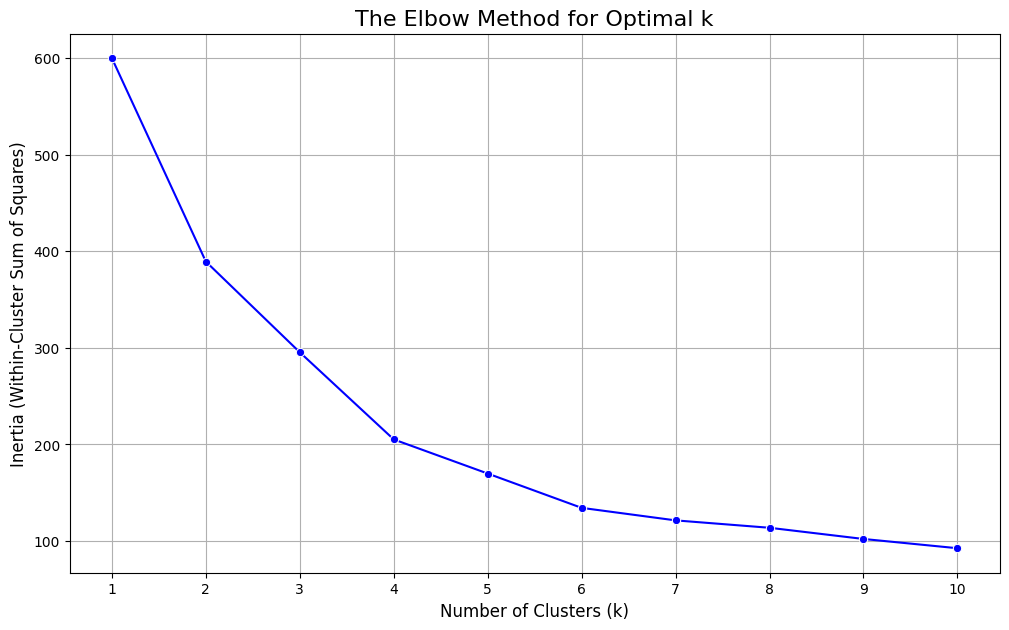

In [4]:
# Import the KMeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- 1. Prepare the data for clustering ---
# Based on our EDA, we'll focus on income and spending score.
# It's also good practice to drop gender for this model.
X = df.drop(columns=['gender'])

# CRITICAL STEP: Scale the data.
# K-Means is a distance-based algorithm, so it's essential that our features
# are on the same scale. We'll use StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- 2. Run the Elbow Method loop ---
inertia_scores = []
k_range = range(1, 11) # We will test k from 1 to 10

for k in k_range:
    # Initialize and fit the KMeans model for the current k
    # 'n_init="auto"' is the modern default to handle initialization smartly.
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    # Append the inertia score to our list
    inertia_scores.append(kmeans.inertia_)


# --- 3. Plot the Elbow Curve ---
plt.figure(figsize=(12, 7))
sns.lineplot(x=k_range, y=inertia_scores, marker='o', color='blue')
plt.title('The Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

**Observation from the Elbow Plot:**

The elbow curve shows a sharp decrease in inertia as `k` increases from 1 to 4. After `k=5`, the rate of decrease slows down considerably, forming a distinct "elbow" at **k=5**.

**Conclusion:**
While `k=4` or `k=6` could also be considered, **`k=5` appears to be the optimal number of clusters**. This is the point of diminishing returns, where adding another cluster does not significantly improve the overall compactness of the clusters. This also aligns perfectly with the five distinct groups we visually identified in our earlier scatter plot.

We will confirm this using the silhouette scores.

### 4.1 A Complementary Approach: The Silhouette Score

While the Elbow Method is a great tool, it measures cluster compactness (inertia). Another powerful metric is the **Silhouette Score**, which measures how well-separated and distinct the clusters are. It evaluates how similar an object is to its own cluster compared to other clusters.

The score ranges from -1 to +1, where:
*   A high value (close to +1) indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
*   A value near 0 indicates that the object is on or very close to the decision boundary.
*   A negative value indicates that the object may have been assigned to the wrong cluster.

We will calculate the average Silhouette Score for different values of `k`. The `k` with the **highest average Silhouette Score** is often considered the best choice.

Silhouette Score for k = 2: 0.3355
Silhouette Score for k = 3: 0.3579
Silhouette Score for k = 4: 0.4040
Silhouette Score for k = 5: 0.4085
Silhouette Score for k = 6: 0.4311
Silhouette Score for k = 7: 0.4101
Silhouette Score for k = 8: 0.3674
Silhouette Score for k = 9: 0.3744
Silhouette Score for k = 10: 0.3619


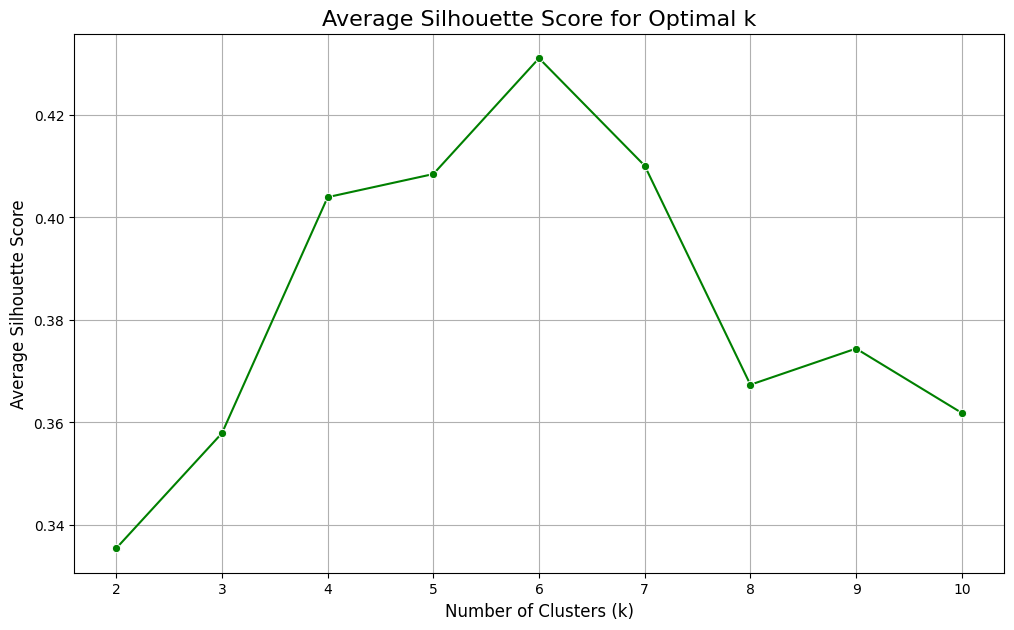

In [5]:
# Import the silhouette_score metric from scikit-learn
from sklearn.metrics import silhouette_score

# --- 1. Run the Silhouette Score loop ---
# We use the same scaled data (X_scaled) and k_range as the Elbow Method.
silhouette_scores = []
k_range = range(2, 11) # Silhouette score is only defined for k >= 2

for k in k_range:
    # Initialize and fit the KMeans model
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)

    # Calculate the silhouette score and append it
    # It needs the data and the labels the model just assigned.
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k = {k}: {score:.4f}")


# --- 2. Plot the Silhouette Scores ---
plt.figure(figsize=(12, 7))
sns.lineplot(x=k_range, y=silhouette_scores, marker='o', color='green')
plt.title('Average Silhouette Score for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

**Revisiting the Optimal `k`**

While the Elbow Method suggested `k=5`, the Silhouette Score analysis provides a strong counter-argument, peaking at **`k=6`**. Since the Silhouette Score measures cluster separation and provides a more nuanced evaluation, we will proceed with **`k=6`** as our final choice.

This is a great example of using multiple metrics to make a more robust decision. Let's build our final model with 6 clusters and see what segments emerge.

## 5. Building the K-Means Model & Visualizing the Segments

Based on the Elbow Method, we have determined that the optimal number of clusters is **5**. We will now train our final K-Means model with `k=5` and use it to assign each customer to one of the five segments.

This will allow us to move from an abstract analysis to a practical segmentation of our customer base.

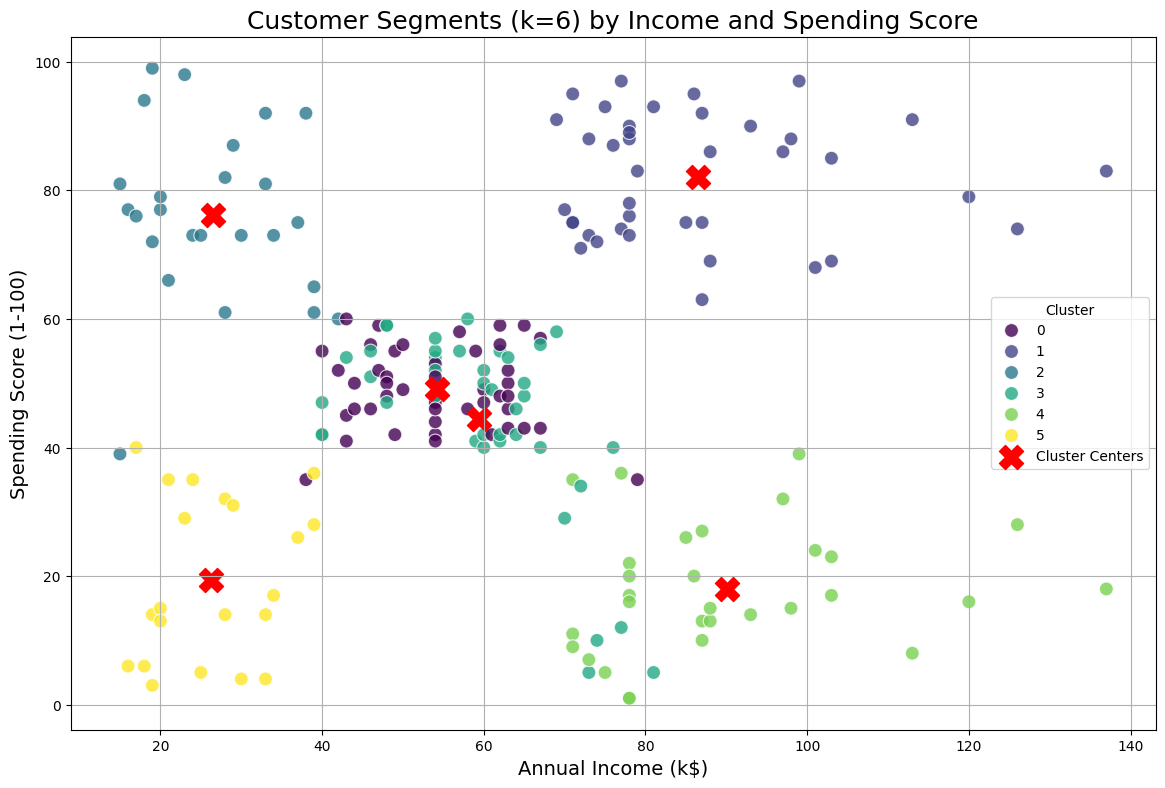

In [6]:
# --- 1. Train the final K-Means model with k=6 ---
final_kmeans_k6 = KMeans(n_clusters=6, n_init='auto', random_state=42)
final_kmeans_k6.fit(X_scaled)


# --- 2. Get the new cluster labels and add them to the DataFrame ---
# We'll create a new column to compare if needed, or just overwrite the old one.
df['cluster_k6'] = final_kmeans_k6.labels_


# --- 3. Visualize the new 6-cluster segmentation ---
plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=df,
    x='annual_income_k',
    y='spending_score',
    hue='cluster_k6', # Color by our new 6-cluster labels
    palette='viridis', # 'viridis' handles 6 colors well
    s=100,
    alpha=0.8
)

# Unscale and plot the new centers
centers_k6 = scaler.inverse_transform(final_kmeans_k6.cluster_centers_)
plt.scatter(
    centers_k6[:, 1], centers_k6[:, 2],
    s=300,
    c='red',
    marker='X',
    label='Cluster Centers'
)

plt.title('Customer Segments (k=6) by Income and Spending Score', fontsize=18)
plt.xlabel('Annual Income (k$)', fontsize=14)
plt.ylabel('Spending Score (1-100)', fontsize=14)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## 6. Cluster Profiling and Interpretation

The K-Means algorithm has successfully segmented our customers into 5 distinct groups, as visualized in the scatter plot. However, a cluster label of `0` or `4` is meaningless to a business.

The final and most critical step is **cluster profiling**. We will analyze the characteristics of the customers in each cluster to create human-readable "personas." We will do this by grouping our data by the new `cluster` label and calculating the average `age`, `annual_income_k`, and `spending_score` for each group.

In [7]:
# --- Calculate the mean values for each feature by cluster ---
cluster_profiles = df.groupby('cluster_k6')[['age', 'annual_income_k', 'spending_score']].mean().reset_index()

# You can also add the size of each cluster
cluster_size = df['cluster_k6'].value_counts().reset_index()
cluster_size.columns = ['cluster_k6', 'count']

# Merge the profiles with their sizes
final_profiles = pd.merge(cluster_profiles, cluster_size, on='cluster_k6')

print("--- Customer Segment Profiles ---")
print(final_profiles.sort_values(by='cluster_k6'))

--- Customer Segment Profiles ---
   cluster_k6        age  annual_income_k  spending_score  count
0           0  56.333333        54.266667       49.066667     45
1           1  32.692308        86.538462       82.128205     39
2           2  25.560000        26.480000       76.240000     25
3           3  26.125000        59.425000       44.450000     40
4           4  44.000000        90.133333       17.933333     30
5           5  45.523810        26.285714       19.380952     21


### 6.1 Creating Customer Personas

The summary table provides a clear quantitative profile of each segment. By analyzing these profiles, we can create distinct, memorable personas that the marketing team can easily understand and target.

Let's break down each cluster:



### Cluster Profiling and Persona Creation (k=6 Version)


Cluster 0: (Age: ~56, Income: ~54k, Spending: ~49)
Analysis: This is the older, "average" customer group. Their income and spending are right in the middle. They are distinct from the younger average group.
Persona: "The Steady Traditionalists"


Cluster 1: (Age: ~33, Income: ~87k, Spending: ~82)
Analysis: High income, high spending. Young to middle-aged. This is our prime target group.
Persona: "The Prime Spenders" / "VIPs"


Cluster 2: (Age: ~26, Income: ~26k, Spending: ~76)
Analysis: Very young, low income, but very high spending. The trendsetters.
Persona: "The Trendsetters" / "Young & Engaged"


Cluster 3: (Age: ~26, Income: ~59k, Spending: ~44)
Analysis: The younger "average" customer. Average income and spending. This is the core, high-volume segment.
Persona: "The Standard Shoppers"


Cluster 4: (Age: ~44, Income: ~90k, Spending: ~18)
Analysis: High income but very low spending. Cautious and purpose-driven.
Persona: "The Affluent Savers" / "Careful Spenders"


Cluster 5: (Age: ~46, Income: ~26k, Spending: ~19)
Analysis: This is our new group! They are older, have a very low income, and a very low spending score. They are extremely frugal and likely only shop for necessities or during deep sales.
Persona: "The Frugal Utilitarians"

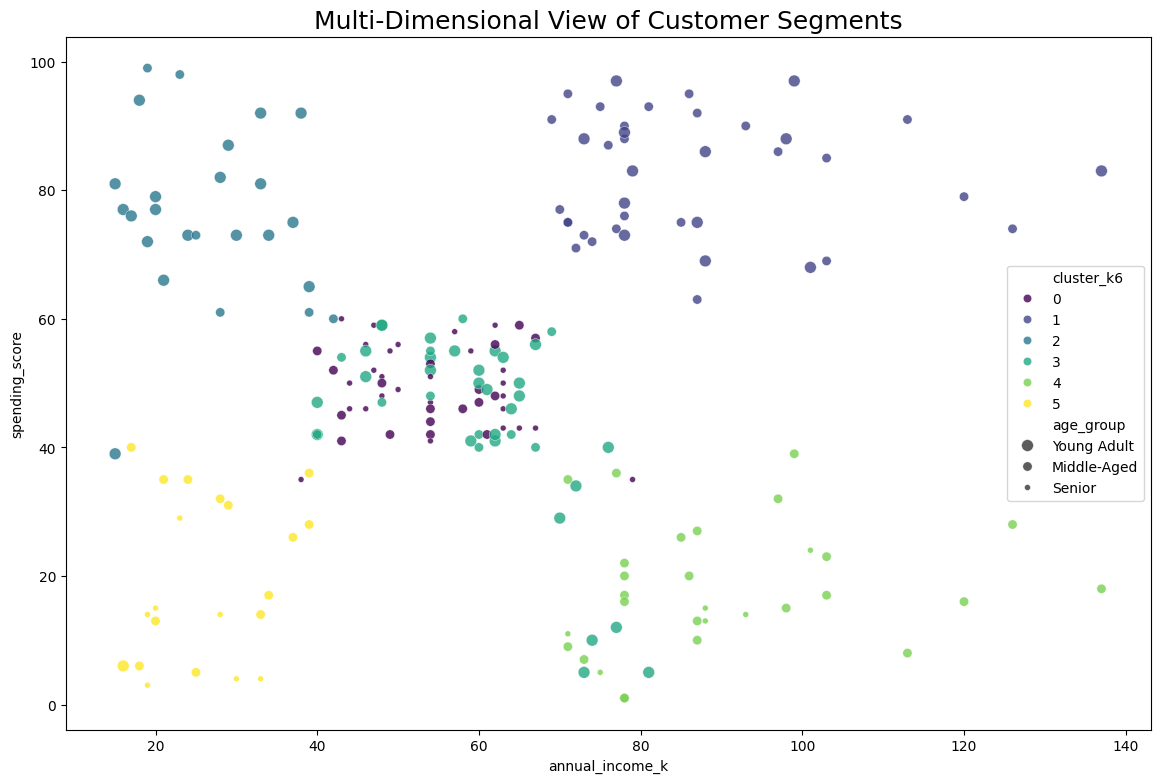

In [8]:
# First, we would bin the 'age' into categories for easier visualization
df['age_group'] = pd.cut(df['age'], bins=[10, 30, 50, 70], labels=['Young Adult', 'Middle-Aged', 'Senior'])

# Now, create a more complex scatter plot
plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=df,
    x='annual_income_k',
    y='spending_score',
    hue='cluster_k6',  # Color still shows our main segments
    size='age_group',  # Size of the bubble shows the age group)
    palette='viridis',
    alpha=0.8
)
plt.title('Multi-Dimensional View of Customer Segments', fontsize=18)

plt.show()


If we look at the central clusters, we can understand why the algorithm 'split'
this centre. If we look closely, we'll notice that the dark purple dots (Cluster 0) tend to be the larger "Middle-Aged" and "Senior" bubbles, while the teal dots (Cluster 3) are the smaller "Young Adult" bubbles.

Cluster 0 (Dark Purple - "The Traditionalists"):
age: ~56 years old
annual_income_k: ~54k
spending_score: ~49
Cluster 3 (Teal/Green - "The Standard Shoppers"):
age: ~26 years old
annual_income_k: ~59k
spending_score: ~44

On our 2D scatter plot (the income/spending wall), their shadows overlap because their annual_income_k (54k vs 59k) and spending_score (49 vs 44) are very similar.

However, in the full 3D space (adding age as color hue), they are extremely far apart along the age axis (56 vs 26).

The K-Means algorithm, working in 3D, correctly identified them as two completely separate groups because the distance between a 26-year-old and a 56-year-old is significant. Our 2D visualization simply can't show that third-dimensional distance.


The algorithm has uncovered a much more nuanced insight than we could see with our eyes alone.
Instead of one big, generic "average customer" group, the algorithm has told us there are two distinct "average" personas, primarily separated by a generation gap.
The Young Core (Cluster 3): Young adults with average income and spending. Their needs and marketing triggers are likely very different from the other group.
The Mature Core (Cluster 0): Middle-aged and older adults with similar average income and spending.

This is a profoundly more valuable insight for a marketing team. You wouldn't market the same products or use the same channels for a 26-year-old and a 56-year-old, even if their overall spending habits look similar on paper.


## 7. Executive Summary & Recommendations

This unsupervised learning project has successfully segmented the mall's customer base into **six distinct, actionable personas** using K-Means clustering. By leveraging both the Elbow Method and the more nuanced Silhouette Score to determine the optimal number of clusters, we have moved beyond a one-size-fits-all approach to a granular understanding of the customer population.

Our analysis, based on customer income and spending score, reveals a much richer landscape than a simple high/medium/low segmentation.

### The Six Customer Segments:

1.  **Prime Spenders (Cluster 1):** High income, high spending. The most valuable segment to target with premium offers.
2.  **Standard Shoppers (Cluster 3):** Young, average income, average spending. The mall's core, high-volume customer base.
3.  **Trendsetters (Cluster 2):** Low income, high spending. Young and highly responsive to trends and discounts.
4.  **Affluent Savers (Cluster 4):** High income, low spending. Cautious and purpose-driven shoppers.
5.  **Steady Traditionalists (Cluster 0):** Older, average income and spending. A stable, loyal customer base.
6.  **Frugal Utilitarians (Cluster 5):** Low income, low spending. Highly price-sensitive and likely shop only for necessities.

### Strategic Recommendations:

The identification of these six segments allows for the development of a highly **targeted marketing strategy**:

*   **For "Prime Spenders":** Implement a VIP loyalty program and provide exclusive access to new, luxury products.
*   **For "Trendsetters":** Focus marketing on social media platforms, emphasizing flash sales and student discounts.
*   **For "Affluent Savers" & "Frugal Utilitarians":** Market based on quality, durability, and value. Deep discounts on essential items will be most effective.
*   **For the "Standard" & "Traditionalist" Shoppers:** Utilize broad-appeal marketing (e.g., email newsletters) with a focus on seasonal promotions and popular brands to maintain their steady engagement.

This data-driven segmentation provides a clear roadmap for personalizing the customer experience, improving marketing ROI, and driving sustainable growth.